# Deep Neural Network for Spatial Decoding from LGN Cells

In this notebook I will use a tensorflow implementation to see how well LGN cells decode location of visual stimulus on the screen. Briefly, LGN units (7-8 total) were selected from several *non-simultaneous* recordings under several criteria:
- <font color='blue'> they should be single units based on the receptive fields obtained from spike-triggered averages
- <font color='blue'> they should NOT be orientation or direction selective (flat tuning curves)
- <font color='blue'> they should be on-center with off-surround.

After selecting units, pearson correlations between all possible pairs (21-28 total) were calculated for each orientation of drifting gratings with and without optogenetic stimulation of SOM nRT neurons. I train a 3-layer neural network on a portion of data and evaluate it on the remaining portion of the data. The question that I am trying to answer is that does optogenetic stimulation affect spatial encoding of LGN cells by altering correlation structure of the pairs.

Let's get started!

## 1 - Packages

Let's first import all the packages that we will need during this analysis. 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [scipy](https://www.scipy.org/) are used here to load .mat file containing correlation data
- [sklearn](https://scikit-learn.org/stable/) a very useful machine learning library
- [TensorFlow](https://www.tensorflow.org/) One of the most useful machine leaning libraries

In [29]:
# Run this cells to install tensorflow library
#!pip install tensorflow
#import tensorflow as tf
#print(tf.__version__)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.python.framework import ops
from tf_utils import random_mini_batches, predict

%matplotlib inline

np.random.seed(1)

## 2 - Dataset

The cell below loads the data and separates it into 3 sets of training (80%), cross-validation (10%), and testing (10%).

**Problem Statement**: The dataset contains:
    - correlations (between 0 and 1) of 21-28 pairs across ~1300 trials (examples)
    - stimulus direction labels (1 to 8) for each trial

Let's get more familiar with the dataset. Load the data by running the cell below.

In [2]:
def load_data(name, idx=0):
    dataset = scipy.io.loadmat(name + '_corr_ws.mat') # change this to somhalo_corr_ws.mat and run
    cc = dataset['cc_vals'][0, idx]
    y = dataset['y_vals'][0, idx]
    
    m = cc.shape[0]
    p = list(np.random.permutation(m))
    X = cc[p, :]
    Y = y[p, :]
    
    m_train = int(.8*X.shape[0])
    m_test = int(.1*X.shape[0])
    
    train_set_x = X[:m_train, :] # train set features
    train_set_y = Y[:m_train, :] # train set labels

    xv_set_x = X[m_train:m_train+m_test, :] # cross-validation set eatures
    xv_set_y = Y[m_train:m_train+m_test, :] # cross-validation set labels

    test_set_x = X[m_train+m_test:, :] # test set features
    test_set_y = Y[m_train+m_test:, :] # test set labels
    
    return train_set_x.T, train_set_y.T, xv_set_x.T, xv_set_y.T, test_set_x.T, test_set_y.T


In [3]:
name = 'somhalo';

train_x_off, train_y_off, xv_x_off, xv_y_off, test_x_off, test_y_off = load_data(name, idx=0) #laser off condition

train_x_on, train_y_on, xv_x_on, xv_y_on, test_x_on, test_y_on = load_data(name, idx=1) #laser on condition

The following code will show you spme of the correlations. 

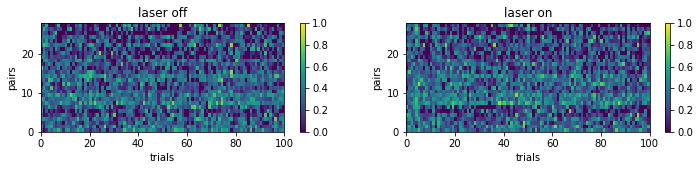

In [9]:
# Example correlation structure
fig = plt.figure(figsize=(12, 2))
plt.subplot(1,2,1)
plt.pcolor(train_x_off[:, :100], vmin=0, vmax=1);
plt.colorbar();
plt.ylabel('pairs');
plt.xlabel('trials');
plt.title('laser off');

plt.subplot(1,2,2)
plt.pcolor(train_x_on[:, :100], vmin=0, vmax=1);
plt.colorbar();
plt.ylabel('pairs');
plt.xlabel('trials');
plt.title('laser on');

In [4]:
# Explore the dataset -- Laser OFF
m_train_off = train_x_off.shape[1]
n_pairs_off = train_x_off.shape[0]
m_xv_off = xv_x_off.shape[1]
m_test_off = test_x_off.shape[1]

print ("Number of training examples: " + str(m_train_off))
print ("Number of cross-validation examples: " + str(m_xv_off))
print ("Number of testing examples: " + str(m_test_off))
print ("train_x shape: " + str(train_x_off.shape))
print ("train_y shape: " + str(train_y_off.shape))

Number of training examples: 1067
Number of cross-validation examples: 133
Number of testing examples: 134
train_x shape: (28, 1067)
train_y shape: (1, 1067)


In [5]:
# Explore the dataset -- Laser ON
m_train_on = train_x_on.shape[1]
n_pairs_on = train_x_on.shape[0]
m_xv_on = xv_x_on.shape[1]
m_test_on = test_x_on.shape[1]

print ("Number of training examples: " + str(m_train_on))
print ("Number of cross-validation examples: " + str(m_xv_on))
print ("Number of testing examples: " + str(m_test_on))
print ("train_x shape: " + str(train_x_on.shape))
print ("train_y shape: " + str(train_y_on.shape))

Number of training examples: 1049
Number of cross-validation examples: 131
Number of testing examples: 132
train_x shape: (28, 1049)
train_y shape: (1, 1049)


The next step in preprocessing the data is to change the labels in such a way that directions 1 and 5, 2 and 6, 3 and 7, 4 and 8 are the same. In other words, we are not decoding for the direction of the stimulus but only the orientation.

In [6]:
print('before: ', train_y_off[0, :10])
train_y_off = train_y_off%5 + train_y_off//5
print('after: ', train_y_off[0, :10])

train_y_on = train_y_on%5 + train_y_on//5

xv_y_off = xv_y_off%5 + xv_y_off//5
xv_y_on = xv_y_on%5 + xv_y_on//5

test_y_off = test_y_off%5 + test_y_off//5
test_y_on = test_y_on%5 + test_y_on//5


before:  [6 3 5 8 5 4 6 7 3 3]
after:  [2 3 1 4 1 4 2 3 3 3]


In [7]:
# Turn labels into one-hot vectors -- Laser OFF
num_classes = 4
train_y_off_oh = np.zeros((num_classes, m_train_off))
for ii in range(m_train_off) :
    train_y_off_oh[train_y_off[0,ii]-1, ii] = 1
    
xv_y_off_oh = np.zeros((num_classes, m_xv_off))
for ii in range(m_xv_off) :
    xv_y_off_oh[xv_y_off[0,ii]-1, ii] = 1
    
test_y_off_oh = np.zeros((num_classes, m_test_off))
for ii in range(m_test_off) :
    test_y_off_oh[test_y_off[0,ii]-1, ii] = 1


In [8]:
# Turn labels into one-hot vectors -- Laser ON
train_y_on_oh = np.zeros((num_classes, m_train_on))
for ii in range(m_train_on) :
    train_y_on_oh[train_y_on[0,ii]-1, ii] = 1
    
xv_y_on_oh = np.zeros((num_classes, m_xv_on))
for ii in range(m_xv_on) :
    xv_y_on_oh[xv_y_on[0,ii]-1, ii] = 1
    
test_y_on_oh = np.zeros((num_classes, m_test_on))
for ii in range(m_test_on) :
    test_y_on_oh[test_y_on[0,ii]-1, ii] = 1

## 3 - Architecture of the model

Now it is time to build a deep neural network to distinguish how accurately stimulus identity can be predicted.

In tensorflow, I will build an 3-layer deep neural network with 64-unit layer followed by a 128-unit layer. Output layer contains $num_classes = 8$ softmax units. Writing and running programs in TensorFlow has the following steps:

1. <font color='blue'> Create Tensors (variables) that are not yet executed/evaluated. 
2. <font color='blue'> Write operations between those Tensors.
3. <font color='blue'> Initialize your Tensors. 
4. <font color='blue'> Create a Session. 
5. <font color='blue'> Run the Session. This will run the operations you'd written above.

Therefore, when we created a variable for the loss, we simply defined the loss as a function of other quantities, but did not evaluate its value. To evaluate it, we had to run `init=tf.global_variables_initializer()`. That initialized the loss variable, and in the last line we were finally able to evaluate the value of `loss` and print its value.

### 3.2 - L-layer deep neural network

It is hard to represent an L-layer deep neural network with the above representation. However, here is a simplified network representation:

<img src="LlayerNN_kiank2.png" style="width:650px;height:400px;">
<caption><center> <u>Figure</u>: L-layer neural network. <br> The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 3</u>:
- The input is 105 by num. of examples)
- The corresponding vector: $[x_0,x_1,...,x_{105}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, you take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, you take the softmax of the final layer to compute the "probability" of each category.

Let's now implement the model!

### 3.1 - Create placeholders

We first create placeholders for `X` and `Y`. This will allow us to later pass the training data in when we run our session. 

In [9]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    Arguments:
        n_x -- scalar, size of an image vector (105)
        n_y -- scalar, number of classes
    
    Returns:
        X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
        Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    """

    X = tf.placeholder(dtype=tf.float32, shape=(n_x, None))
    Y = tf.placeholder(dtype=tf.float32, shape=(n_y, None))
    
    return X, Y

In [16]:
X, Y = create_placeholders(28, 4)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("Placeholder:0", shape=(28, ?), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(4, ?), dtype=float32)


### 3.2 - Initializing the parameters

Now we initialize the parameters in tensorflow using Xavier Initialization for weights and Zero Initialization for biases.

In [10]:
def initialize_parameters(n_pairs, num_classes=4):
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [64, n_pairs]
                        b1 : [64, 1]
                        W2 : [64, 64]
                        b2 : [64, 1]
                        W3 : [num_classes, 64]
                        b3 : [num_classes, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
            
    W1 = tf.get_variable(dtype=tf.float32, name='W1', shape=(64,n_pairs), 
                         initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.Variable(np.zeros((64,1)), dtype=tf.float32, name='b1')
    
    W2 = tf.get_variable(dtype=tf.float32, name='W2', shape=(64,64), 
                         initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.Variable(np.zeros((64,1)), dtype=tf.float32, name='b2')
    
    W3 = tf.get_variable(dtype=tf.float32, name='W3', shape=(num_classes,64), 
                         initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.Variable(np.zeros((num_classes,1)), dtype=tf.float32, name='b3')

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [18]:
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters(n_pairs=28)
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))
    print("W3 = " + str(parameters["W3"]))
    print("b3 = " + str(parameters["b3"]))

W1 = <tf.Variable 'W1:0' shape=(64, 28) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(64, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(64, 64) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(64, 1) dtype=float32_ref>
W3 = <tf.Variable 'W3:0' shape=(4, 64) dtype=float32_ref>
b3 = <tf.Variable 'b3:0' shape=(4, 1) dtype=float32_ref>


### 3.3 - Forward propagation in tensorflow 

We will now implement the forward propagation module in tensorflow. The function will take in a dictionary of parameters and it will complete the forward pass. The functions we will be using are: 

- `tf.add(...,...)` to do an addition
- `tf.matmul(...,...)` to do a matrix multiplication
- `tf.nn.relu(...)` to apply the ReLU activation


In [11]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    Arguments:
        X -- input dataset placeholder, of shape (input size, number of examples)
        parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                      the shapes are given in initialize_parameters
    Returns:
        Z3 -- the output of the last LINEAR unit
    """
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = tf.matmul(W1, X) + b1                                       # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                              # A1 = relu(Z1)
    Z2 = tf.matmul(W2, A1) + b2                                      # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                              # A2 = relu(Z2)
    Z3 = tf.matmul(W3, A2) + b3                                      # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

In [20]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(28, num_classes)
    parameters = initialize_parameters(28, num_classes)
    Z3 = forward_propagation(X, parameters)
    print("Z3 = " + str(Z3))

Z3 = Tensor("add_2:0", shape=(4, ?), dtype=float32)


### 3.4 Compute cost

Cost function was calculated through this command:
```python
tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = ..., labels = ...))
```


In [12]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    Arguments:
        Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (8, num. of examples)
        Y -- "true" labels vector placeholder, same shape as Z3
    Returns:
        cost - Tensor of the cost function
    """
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))
    
    return cost

In [22]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(28, num_classes)
    parameters = initialize_parameters(n_pairs=28)
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    print("cost = " + str(cost))

cost = Tensor("Mean:0", shape=(), dtype=float32)


### 3.5 - Backward propagation & parameter updates

This is where the programming frameworks come in handy! All the backpropagation and the parameters update is taken care of in 1 line of code. It is very easy to incorporate this line in the model. We will create an "`optimizer`" object and call this object along with the cost when running the tf.session. When called, it will perform an optimization on the given cost with the chosen method and learning rate. This computes the backpropagation by passing through the tensorflow graph in the reverse order from cost to inputs.


### 3.6 - Building the model

Now, we will bring it all together! 

In [13]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.002,
          num_epochs=2000, minibatch_size=32, print_cost=True):
    """
    Implements a 3-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    Arguments:
        X_train -- training set, of shape (n_pairs, num. of training examples)
        Y_train -- test set, of shape (num_classes, num. of training examples)
        X_test -- training set, of shape (n_pairs, num. of test examples)
        Y_test -- test set, of shape (num_classes, num. of test examples)
        learning_rate -- learning rate of the optimization
        num_epochs -- number of epochs of the optimization loop
        minibatch_size -- size of a minibatch
        print_cost -- True to print the cost every 100 epochs
    Returns:
        parameters -- parameters learnt by the model. They can then be used to predict.
        training accuracy -- scalar
        test accuracy -- scalar
    """
    
    ops.reset_default_graph()                         
    (n_x, m) = X_train.shape            # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]              # n_y : output size
    costs = []                          # To keep track of the cost
    
    # Creating Placeholders of shape (n_x, n_y)
    X, Y = create_placeholders(n_x, n_y)

    # Initializing parameters
    parameters = initialize_parameters(n_x, n_y)
    
    # Forward propagation: Building the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Adding cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Defining the tensorflow optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initializing all the variables
    init = tf.global_variables_initializer()

    # Starting the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Running the initialization
        sess.run(init)
        
        # loop over training examples
        for epoch in range(num_epochs):

            epoch_cost = 0.                 
            num_minibatches = int(m/minibatch_size) # number of minibatches of size minibatch_size in the train set
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                (minibatch_X, minibatch_Y) = minibatch  # Select a minibatch
                
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 10 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        if print_cost == True :
            plt.plot(np.squeeze(costs))
            plt.ylabel('cost')
            plt.xlabel('iterations (per tens)')
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters, accuracy.eval({X: X_train, Y: Y_train}), accuracy.eval({X: X_test, Y: Y_test})

Run the cell below to train the parameters. The cost should be decreasing. It may take several minutes to run over the iterations.

We are going to tune hyperparameters using the cross-validation set and at the last step we evaluate the performance of the model on the dataset it hasn't seen before (test set).

In [24]:
num_epochs = range(1000, 5000, 500);
learning_rates = [3e-3, 4e-3, 5e-3, 6e-3]
train_acc = np.zeros((8, 4)); 
xv_acc = np.zeros((8, 4));
for ii, nsteps in enumerate(num_epochs) :
    for jj, lr in enumerate(learning_rates) :
        print(nsteps, lr)
        parameters, acc1, acc2 = model(train_x_off, train_y_off_oh, xv_x_off, xv_y_off_oh, learning_rate=lr,
                                       num_epochs=nsteps, print_cost=False)
        train_acc[ii, jj] = acc1
        xv_acc[ii, jj] = acc2
        
scipy.io.savemat(name + '_scanning_params.mat', {'train_acc': train_acc, 'xv_acc': xv_acc})

1000 0.003
Parameters have been trained!
Train Accuracy: 0.569822
Test Accuracy: 0.43609
1000 0.004
Parameters have been trained!
Train Accuracy: 0.609185
Test Accuracy: 0.43609
1000 0.005
Parameters have been trained!
Train Accuracy: 0.661668
Test Accuracy: 0.451128
1000 0.006
Parameters have been trained!
Train Accuracy: 0.708529
Test Accuracy: 0.398496
1500 0.003
Parameters have been trained!
Train Accuracy: 0.628866
Test Accuracy: 0.443609
1500 0.004
Parameters have been trained!
Train Accuracy: 0.701031
Test Accuracy: 0.428571
1500 0.005
Parameters have been trained!
Train Accuracy: 0.766635
Test Accuracy: 0.443609
1500 0.006
Parameters have been trained!
Train Accuracy: 0.805061
Test Accuracy: 0.421053
2000 0.003
Parameters have been trained!
Train Accuracy: 0.701031
Test Accuracy: 0.413534
2000 0.004
Parameters have been trained!
Train Accuracy: 0.787254
Test Accuracy: 0.43609
2000 0.005
Parameters have been trained!
Train Accuracy: 0.877226
Test Accuracy: 0.43609
2000 0.006
Par

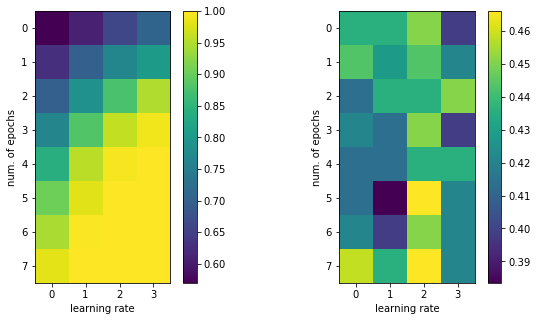

In [25]:
fig = plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.imshow(train_acc)
plt.colorbar()
plt.ylabel('num. of epochs');
plt.xlabel('learning rate');

plt.subplot(1,2,2)
plt.imshow(xv_acc)
plt.colorbar()
plt.ylabel('num. of epochs');
plt.xlabel('learning rate');

Cost after epoch 0: 1.430622
Cost after epoch 100: 1.313126
Cost after epoch 200: 1.185935
Cost after epoch 300: 1.130210
Cost after epoch 400: 1.113258
Cost after epoch 500: 1.088075
Cost after epoch 600: 1.068681
Cost after epoch 700: 1.042539
Cost after epoch 800: 0.998736
Cost after epoch 900: 0.952329
Cost after epoch 1000: 0.903666
Cost after epoch 1100: 0.861273
Cost after epoch 1200: 0.811643
Cost after epoch 1300: 0.758298
Cost after epoch 1400: 0.710430
Cost after epoch 1500: 0.661699
Cost after epoch 1600: 0.605373
Cost after epoch 1700: 0.559831
Cost after epoch 1800: 0.514811
Cost after epoch 1900: 0.459366
Cost after epoch 2000: 0.421060
Cost after epoch 2100: 0.384504
Cost after epoch 2200: 0.332821
Cost after epoch 2300: 0.298879
Cost after epoch 2400: 0.256891
Cost after epoch 2500: 0.227619
Cost after epoch 2600: 0.197756
Cost after epoch 2700: 0.169861
Cost after epoch 2800: 0.148598
Cost after epoch 2900: 0.128494
Cost after epoch 3000: 0.111284
Cost after epoch 310

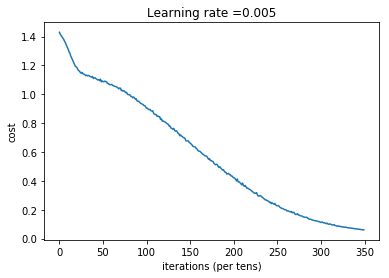

Parameters have been trained!
Train Accuracy: 0.999063
Test Accuracy: 0.477612


In [26]:
parameters, acc1, acc2 = model(train_x_off, train_y_off_oh, test_x_off, test_y_off_oh, learning_rate=5e-3,
                                       num_epochs=3500, print_cost=True)

### 3.7 - Run the model multiple times


In [ ]:
stim_test_acc =[];
for ii in range(1,51) :
    parameters, acc1, acc2 = model(train_x_off, train_y_off_oh, test_x_off, test_y_off_oh, learning_rate=5e-3,
                                       num_epochs=3500, print_cost=False)
    stim_test_acc.append(acc2)
    if ii%5 == 0 :
        scipy.io.savemat(name + '_stim_test_acc' + str(ii) + '.mat', {'stim_test_acc': stim_test_acc})

Parameters have been trained!
Train Accuracy: 0.999063
Test Accuracy: 0.485075
Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 0.477612
Parameters have been trained!
Train Accuracy: 0.999063
Test Accuracy: 0.440298
Parameters have been trained!
Train Accuracy: 0.999063
Test Accuracy: 0.462687
Parameters have been trained!
Train Accuracy: 0.999063
Test Accuracy: 0.455224
Parameters have been trained!
Train Accuracy: 0.999063
Test Accuracy: 0.432836
Parameters have been trained!
Train Accuracy: 0.999063
Test Accuracy: 0.455224
Parameters have been trained!
Train Accuracy: 0.999063
Test Accuracy: 0.477612
Parameters have been trained!
Train Accuracy: 0.999063
Test Accuracy: 0.410448
Parameters have been trained!
Train Accuracy: 0.998126
Test Accuracy: 0.447761
Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 0.470149
Parameters have been trained!
Train Accuracy: 0.999063
Test Accuracy: 0.440298
Parameters have been trained!
Train Accuracy: 0.998126
Test Ac

### 3.8 - Run the model on shuffle data


In [14]:
p = list(np.random.permutation(m_test_off))
shuff_test_y_off = test_y_off[0, p]

shuff_test_y_off_oh = np.zeros((num_classes, m_test_off))
for ii in range(m_test_off) :
    shuff_test_y_off_oh[shuff_test_y_off[ii]-1, ii] = 1
    
shuff_test_acc =[];
for ii in range(1,6) :
    parameters, acc1, acc2 = model(train_x_off, train_y_off_oh, test_x_off, shuff_test_y_off_oh, learning_rate=5e-3,
                                       num_epochs=3500, print_cost=False)
    shuff_test_acc.append(acc2)
    if ii%5 == 0 :
        scipy.io.savemat(name + '_shuff_test_acc' + str(ii) + '.mat', {'shuff_test_acc': shuff_test_acc})
        

Parameters have been trained!
Train Accuracy: 0.997188
Test Accuracy: 0.253731
Parameters have been trained!
Train Accuracy: 0.996251
Test Accuracy: 0.261194
Parameters have been trained!
Train Accuracy: 0.996251
Test Accuracy: 0.238806
Parameters have been trained!
Train Accuracy: 0.997188
Test Accuracy: 0.216418
Parameters have been trained!
Train Accuracy: 0.991565
Test Accuracy: 0.231343


### 3.9 Train the model on laser on condition

In [15]:
num_epochs = range(1000, 5000, 500);
learning_rates = [3e-3, 4e-3, 5e-3, 6e-3]
train_acc = np.zeros((8, 4)); 
xv_acc = np.zeros((8, 4));
for ii, nsteps in enumerate(num_epochs) :
    for jj, lr in enumerate(learning_rates) :
        print(nsteps, lr)
        parameters, acc1, acc2 = model(train_x_on, train_y_on_oh, xv_x_on, xv_y_on_oh, learning_rate=lr,
                                       num_epochs=nsteps, print_cost=False)
        train_acc[ii, jj] = acc1
        xv_acc[ii, jj] = acc2
        
scipy.io.savemat(name + '&opto_scanning_params.mat', {'train_acc': train_acc, 'xv_acc': xv_acc})

1000 0.003
Parameters have been trained!
Train Accuracy: 0.491897
Test Accuracy: 0.396947
1000 0.004
Parameters have been trained!
Train Accuracy: 0.536702
Test Accuracy: 0.366412
1000 0.005
Parameters have been trained!
Train Accuracy: 0.572927
Test Accuracy: 0.320611
1000 0.006
Parameters have been trained!
Train Accuracy: 0.63775
Test Accuracy: 0.312977
1500 0.003
Parameters have been trained!
Train Accuracy: 0.558627
Test Accuracy: 0.343511
1500 0.004
Parameters have been trained!
Train Accuracy: 0.647283
Test Accuracy: 0.320611
1500 0.005
Parameters have been trained!
Train Accuracy: 0.763584
Test Accuracy: 0.374046
1500 0.006
Parameters have been trained!
Train Accuracy: 0.833174
Test Accuracy: 0.366412
2000 0.003
Parameters have been trained!
Train Accuracy: 0.650143
Test Accuracy: 0.351145
2000 0.004
Parameters have been trained!
Train Accuracy: 0.787417
Test Accuracy: 0.366412
2000 0.005
Parameters have been trained!
Train Accuracy: 0.894185
Test Accuracy: 0.396947
2000 0.006


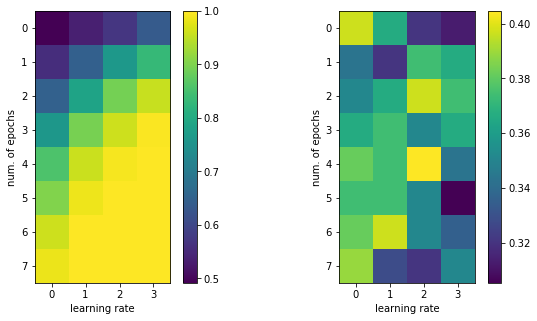

In [16]:
fig = plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.imshow(train_acc)
plt.colorbar()
plt.ylabel('num. of epochs');
plt.xlabel('learning rate');

plt.subplot(1,2,2)
plt.imshow(xv_acc)
plt.colorbar()
plt.ylabel('num. of epochs');
plt.xlabel('learning rate');

### 3.10 - Run the model multiple times


In [17]:
stimopto_test_acc =[];
for ii in range(1,51) :
    parameters, acc1, acc2 = model(train_x_on, train_y_on_oh, test_x_on, test_y_on_oh, learning_rate=5e-3,
                                       num_epochs=3000, print_cost=False)
    stimopto_test_acc.append(acc2)
    if ii%5 == 0 :
        scipy.io.savemat(name + '_stim&opto_test_acc' + str(ii) + '.mat', {'stimopto_test_acc': stimopto_test_acc})

Parameters have been trained!
Train Accuracy: 0.993327
Test Accuracy: 0.401515
Parameters have been trained!
Train Accuracy: 0.99714
Test Accuracy: 0.340909
Parameters have been trained!
Train Accuracy: 0.993327
Test Accuracy: 0.356061
Parameters have been trained!
Train Accuracy: 0.992374
Test Accuracy: 0.424242
Parameters have been trained!
Train Accuracy: 0.993327
Test Accuracy: 0.393939
Parameters have been trained!
Train Accuracy: 0.99714
Test Accuracy: 0.393939
Parameters have been trained!
Train Accuracy: 0.995234
Test Accuracy: 0.363636
Parameters have been trained!
Train Accuracy: 0.99428
Test Accuracy: 0.363636
Parameters have been trained!
Train Accuracy: 0.996187
Test Accuracy: 0.363636
Parameters have been trained!
Train Accuracy: 0.990467
Test Accuracy: 0.371212
Parameters have been trained!
Train Accuracy: 0.992374
Test Accuracy: 0.386364
Parameters have been trained!
Train Accuracy: 0.99142
Test Accuracy: 0.401515
Parameters have been trained!
Train Accuracy: 0.995234
T